## **Descarga de Bases**

In [1]:
from google.colab import drive

# Montamos nuestra unidad drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Nos dirigimos a la carpeta con los inputs
%cd /content/drive/MyDrive/TA/

# %cd /content/drive/My\ Drive/2021-1/TAC/TA

/content/drive/.shortcut-targets-by-id/1E6FH8qATLyjIcq0TwQVxmCJ1SdpR4yZr/TA


In [3]:
%ls -l

total 2396
-r-------- 1 root root 1118547 Jun 30 00:17 'Copia de TA Final Preprocesamiento.ipynb'
dr-x------ 2 root root    4096 Jun 29 17:04  data/
-r-------- 1 root root 1118547 Jun 29 23:53 'TA Final Preprocesamiento.ipynb'
-r-------- 1 root root  211825 Jun 29 23:36  test.png


### **Imports**

In [4]:
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random

import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [5]:
%tensorflow_version 2.x
from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(0)

## **Lectura de imágenes**

In [6]:
# Creamos una carpeta para descomprimir las imagenes
#!mkdir data
# !cd data && unzip BSDS300-images.zip

# Si la carpeta ya esta creada, nos dirigimos a esta
%cd data/

/content/drive/.shortcut-targets-by-id/1E6FH8qATLyjIcq0TwQVxmCJ1SdpR4yZr/TA/data


In [7]:
%ls -l

total 21716
dr-x------ 2 root root     4096 Jun 29 17:54 BSDS300/
-r-------- 1 root root 22232571 Jun 29 17:19 BSDS300-images.zip


In [8]:
# srcPath = '/content/drive/My Drive/2021-1/TAC/TA/data/BSDS300/images'
srcPath = 'BSDS300/images'

train_scan_paths = os.listdir(srcPath + '/train')
test_scan_paths = os.listdir(srcPath + '/test')

train_scan_paths = [(srcPath + '/train/' + x) for x in train_scan_paths]
test_scan_paths = [(srcPath + '/test/' + x) for x in test_scan_paths]


print("train scan with length of: {}".format(len(train_scan_paths)))
print("test scan with length of: {}".format(len(test_scan_paths)))

train scan with length of: 200
test scan with length of: 100


In [9]:
train_scan_paths[:5]

['BSDS300/images/train/365025.jpg',
 'BSDS300/images/train/20008.jpg',
 'BSDS300/images/train/232038.jpg',
 'BSDS300/images/train/188091.jpg',
 'BSDS300/images/train/286092.jpg']

In [10]:
test_scan_paths[:5]

['BSDS300/images/test/170057.jpg',
 'BSDS300/images/test/163085.jpg',
 'BSDS300/images/test/220075.jpg',
 'BSDS300/images/test/167062.jpg',
 'BSDS300/images/test/43074.jpg']

## **Preprocesamiento**

In [11]:
def normalize_scan(image):
  
  norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  return norm_image

def resize_scan(scan, desired_width, desired_height):
  
  scan = cv2.resize(scan, (desired_height, desired_width))
  return scan

def preprocess_scan(path, width, height):
  
  scan = image.imread(path)
  resized_scan = resize_scan(scan, width, height)
  normalized_resized_scan = normalize_scan(resized_scan)

  return resized_scan


In [12]:
width = 256
height = 256

In [13]:
train_scans = [preprocess_scan(path, width, height) for path in train_scan_paths]
test_scans = [preprocess_scan(path, width, height) for path in test_scan_paths]

In [14]:
train_scans[0].shape

(256, 256, 3)

(-0.5, 255.5, 255.5, -0.5)

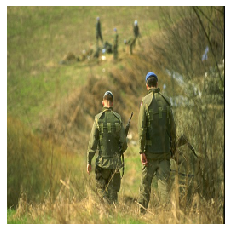

In [97]:
data = train_scans[0]
img = plt.imshow(data, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')

In [16]:
data = train_scans[0]

def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

noise_img = sp_noise(data,0.05)

(-0.5, 255.5, 255.5, -0.5)

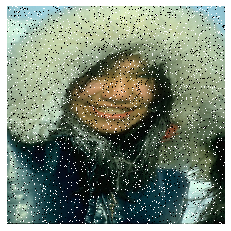

In [17]:
img = plt.imshow(noise_img, interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')

In [91]:
data = train_scans[1]

def gauss_noise(image):
      row,col,ch= image.shape
      mean = 0
      var = 10
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy

gauss_img = gauss_noise(data)

In [19]:
def gauss_noise_2(image, std):
  noise = np.random.normal(0, std, (image.shape[0], image.shape[1], 1))
  # Add noise and clip
  noise_img = np.array(image) + noise
  noise_img = np.clip(noise_img, 0, 255).astype(np.uint8)
  return noise_img

In [92]:
gauss_img_2 = gauss_noise_2(data, 10)

(-0.5, 255.5, 255.5, -0.5)

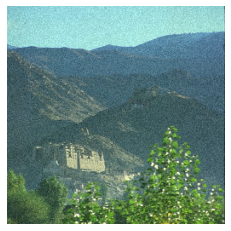

In [95]:
img = plt.imshow(gauss_img_2)
img.set_cmap('hot')
plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')

In [22]:
def poisson_noise(img):
  noise_mask = np.random.poisson(img)

  noisy_img = img + noise_mask
  return noisy_img

data = train_scans[0]
noisy_img = poisson_noise(data)

(-0.5, 255.5, 255.5, -0.5)

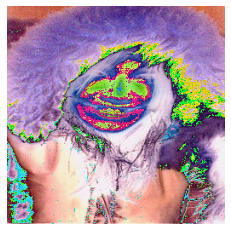

In [23]:
img = plt.imshow((noisy_img * 255).astype(np.uint8))
img.set_cmap('hot')
plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight')

## **Ruido Gaussiano - Dataset Imagenes**

In [24]:
train_gaussian_noise_images = [gauss_noise_2(x, 10) for x in train_scans]
test_gaussian_noise_images = [gauss_noise_2(x, 10) for x in test_scans]

In [25]:
N_CHANNELS = 3

In [26]:
train_gaussian_noise_images = np.array(train_gaussian_noise_images).reshape((-1, width, height, N_CHANNELS)).astype(np.float32)
test_gaussian_noise_images = np.array(test_gaussian_noise_images).reshape((-1, width, height, N_CHANNELS)).astype(np.float32)

In [27]:
train_target_images = np.array(train_scans).astype(np.float32)
test_target_images = np.array(test_scans).astype(np.float32)

In [28]:
# Funcion de perdida - MSE
from tensorflow.keras.losses import MeanSquaredError

mse = tf.keras.losses.MeanSquaredError()
mse(train_gaussian_noise_images[0], train_scans[0].astype(np.float32)).numpy()

95.12637

In [29]:
# Batch size
BATCH_SIZE = 20

# Train size
train_gaussian_noise_images.shape[0]

# Epochs number
EPOCHS = (int)(train_gaussian_noise_images.shape[0]/BATCH_SIZE)
print("Numero de epocas: {}".format(EPOCHS))

Numero de epocas: 10


## **MODELAMIENTO**

In [34]:
from keras import Input, Model
from keras import layers

In [126]:
from keras import backend as K
K.clear_session()

In [127]:
def Autoencoder():
  
  input_img = Input(shape=(256, 256, 3))  

  # ============================================================================
  # == ENCODER
  # ============================================================================

  conv_1_a = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(input_img)
  l_relu_1_a = layers.LeakyReLU()(conv_1_a)
  conv_1_b = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(l_relu_1_a)
  l_relu_1_b = layers.LeakyReLU()(conv_1_b)
  maxpool_1 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_1_b)

  conv_2 = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(maxpool_1)
  l_relu_2 = layers.LeakyReLU()(conv_2)
  maxpool_2 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_2)
  # encoded = layers.MaxPooling2D((2, 2), padding='same')(l_relu_2)

  conv_3 = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(maxpool_2)
  l_relu_3 = layers.LeakyReLU()(conv_3)
  maxpool_3 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_3)

  conv_4 = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(maxpool_3)
  l_relu_4 = layers.LeakyReLU()(conv_4)
  maxpool_4 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_4)

  conv_5_a = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(maxpool_4)
  l_relu_5_a = layers.LeakyReLU()(conv_5_a)
  maxpool_5 = layers.MaxPooling2D((2, 2), padding='same')(l_relu_5_a)
  conv_5_b = layers.Conv2D(48, (2, 2), padding='same', use_bias=True)(maxpool_5)
  encoded = layers.LeakyReLU()(conv_5_b)

  # ============================================================================
  # == DECODER
  # ============================================================================

  upsamp_6 = layers.UpSampling2D((2, 2))(encoded)
  conv_6_a = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(upsamp_6)
  l_relu_6_a = layers.LeakyReLU()(conv_6_a)
  conv_6_b = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(l_relu_6_a)
  l_relu_6_b = layers.LeakyReLU()(conv_6_b)

  upsamp_7 = layers.UpSampling2D((2, 2))(l_relu_6_b)
  conv_7_a = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(upsamp_7)
  l_relu_7_a = layers.LeakyReLU()(conv_7_a)
  conv_7_b = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(l_relu_7_a)
  l_relu_7_b = layers.LeakyReLU()(conv_7_b)

  upsamp_8 = layers.UpSampling2D((2, 2))(l_relu_7_b)
  conv_8_a = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(upsamp_8)
  l_relu_8_a = layers.LeakyReLU()(conv_8_a)
  conv_8_b = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(l_relu_8_a)
  l_relu_8_b = layers.LeakyReLU()(conv_8_b)

  upsamp_9 = layers.UpSampling2D((2, 2))(l_relu_8_b)
  conv_9_a = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(upsamp_9)
  l_relu_9_a = layers.LeakyReLU()(conv_9_a)
  conv_9_b = layers.Conv2D(96, (2, 2), padding='same', use_bias=True)(l_relu_9_a)
  l_relu_9_b = layers.LeakyReLU()(conv_9_b)

  upsamp_10 = layers.UpSampling2D((2, 2))(l_relu_9_b)
  conv_10_a = layers.Conv2D(64, (2, 2), padding='same', use_bias=True)(upsamp_10)
  l_relu_10_a = layers.LeakyReLU()(conv_10_a)
  conv_10_b = layers.Conv2D(32, (2, 2), padding='same', use_bias=True)(l_relu_10_a)
  l_relu_10_b = layers.LeakyReLU()(conv_10_b)

  decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(l_relu_10_b)
  # decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l_relu_7_b)

  return Model(input_img, decoded)

In [128]:
autoencoder = Autoencoder()

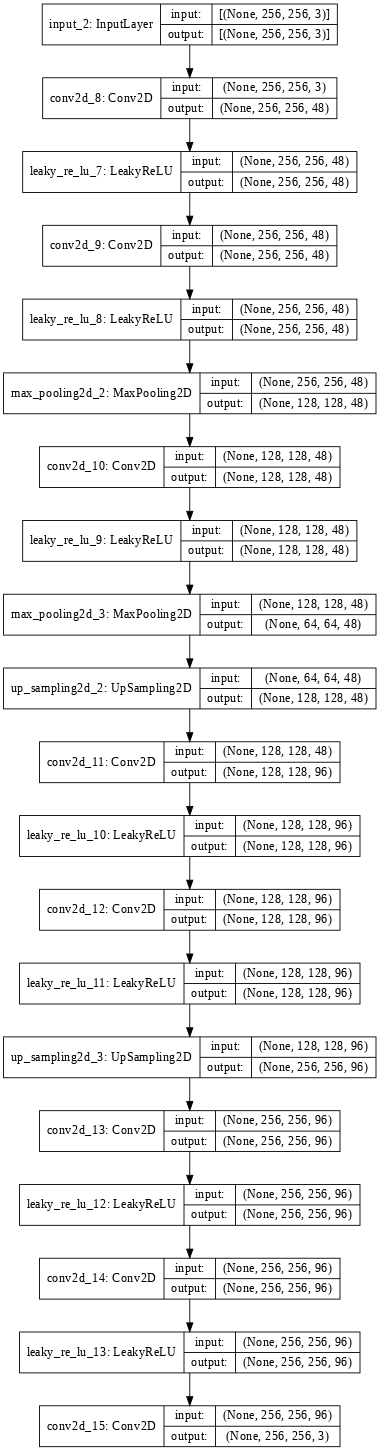

In [74]:
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, show_shapes=True, dpi=64)

In [129]:
from tensorflow.keras.optimizers import Adam

# Definimos la funcion de optimizacion
autoencoder_optimizer = Adam(0.001, beta_1=0.9)

In [130]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=autoencoder_optimizer,
                                 autoencoder=autoencoder)

## **Training**

In [41]:
# %cd /content/drive/My Drive/TA_02_TAC
# %ls -l

/content/drive/My Drive/TA_02_TAC
total 90
drwx------ 2 root root  4096 Jun 30 04:57 logs/
-rw------- 1 root root 87463 Jun 30 05:02 model.png
-rw------- 1 root root   151 Jun 10 00:39 PPT_TAC_Modelo_y_Propuesta.gslides


In [77]:
from datetime import datetime
import time
import os

if not os.path.isdir('logs'):
  os.mkdir('logs')

log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

In [131]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as autoencoder_tape:
    autoencoder_output = autoencoder(input_image, training=True)

    mse_loss = mse(autoencoder_output, target)

  autoencoder_gradients = autoencoder_tape.gradient(mse_loss,
                                          autoencoder.trainable_variables)
  autoencoder_optimizer.apply_gradients(zip(autoencoder_gradients,
                                          autoencoder.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('autoencoder_mse_loss', mse_loss, step=epoch)

In [79]:
def fit(train_ds, epochs):
  for epoch in range(epochs):
    start = time.time()

    # display.clear_output(wait=True)

    # for example_input, example_target in test_ds.take(1):
    #   generate_images(generator, example_input, example_target)
    # print("Epoch: ", epoch)

    # Training step
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # Saving (checkpointing) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

In [80]:
train_tuple = list(zip(train_target_images, train_target_images))

In [81]:
from tensorflow.data import Dataset

ds_train_images = Dataset.from_tensor_slices(train_gaussian_noise_images)
ds_target_images = Dataset.from_tensor_slices(train_target_images)

train_dataset = Dataset.zip((ds_train_images,ds_target_images))
train_dataset = train_dataset.batch(BATCH_SIZE)

In [82]:
tf.config.run_functions_eagerly(True)

In [83]:
fit(train_dataset, EPOCHS)

..........
Time taken for epoch 1 is 7.942696571350098 sec

..........
Time taken for epoch 2 is 7.115707635879517 sec

..........
Time taken for epoch 3 is 7.1374523639678955 sec

..........
Time taken for epoch 4 is 7.197718620300293 sec

..........
Time taken for epoch 5 is 7.227152109146118 sec

..........
Time taken for epoch 6 is 7.278116226196289 sec

..........
Time taken for epoch 7 is 7.350867748260498 sec

..........
Time taken for epoch 8 is 7.383350372314453 sec

..........
Time taken for epoch 9 is 7.4156904220581055 sec

..........
Time taken for epoch 10 is 7.3973469734191895 sec



## **MODELING 2**

In [ ]:
# == PRUEBA 2

In [132]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [134]:
autoencoder.fit(train_gaussian_noise_images, train_target_images,
                epochs=30,
                shuffle=True,
                validation_data=(test_gaussian_noise_images, test_target_images))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
7/7 [==============================] - 7s 1s/step - loss: 14734.3008 - val_loss: 14502.1367
Epoch 2/30
7/7 [==============================] - 7s 943ms/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 3/30
7/7 [==============================] - 7s 951ms/step - loss: 14734.3008 - val_loss: 14502.1367
Epoch 4/30
7/7 [==============================] - 7s 967ms/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 5/30
7/7 [==============================] - 7s 967ms/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 6/30
7/7 [==============================] - 7s 1s/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 7/30
7/7 [==============================] - 7s 964ms/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 8/30
7/7 [==============================] - 7s 955ms/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 9/30
7/7 [==============================] - 7s 954ms/step - loss: 14734.3027 - val_loss: 14502.1367
Epoch 10/30
7/7 [==============================] - 7

## **Testing**

In [84]:
ds_test_images = Dataset.from_tensor_slices(test_gaussian_noise_images)
ds_test_target_images = Dataset.from_tensor_slices(test_target_images)

test_dataset = Dataset.zip((ds_test_images,ds_test_target_images))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [122]:
def generate_images(model, test_input, tar):
  prediction = model.predict(test_input)
  plt.figure(figsize=(15, 15))

  print(prediction)

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    img = plt.imshow(tf.cast((display_list[i] * 255),np.uint8))
    # img.set_cmap('hot')
    plt.axis('off')

    # plt.imshow(display_list[i])
    # plt.axis('off')

  plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1. 

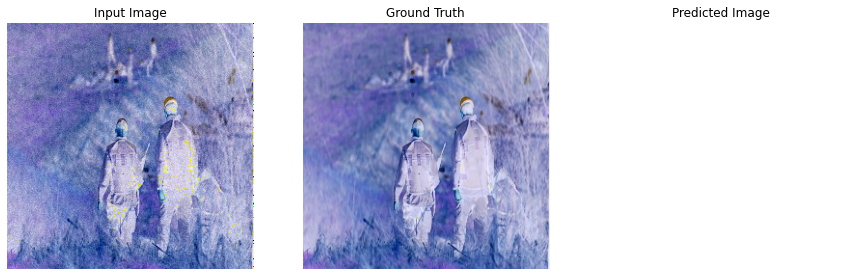

[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1

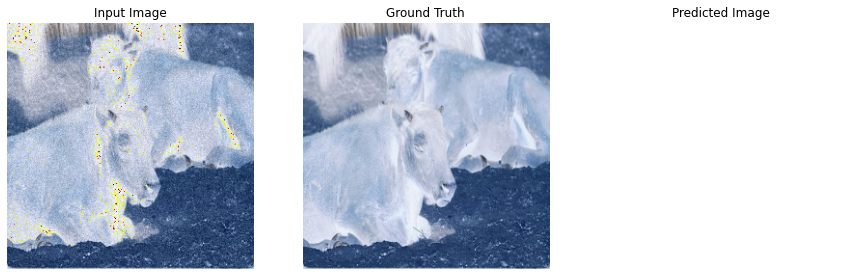

[[[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]]


 [[[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  ...

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]]

  [[1. 1. 1.]
   [1. 1. 1.]
   [1. 1. 1.]
   ...
   [1

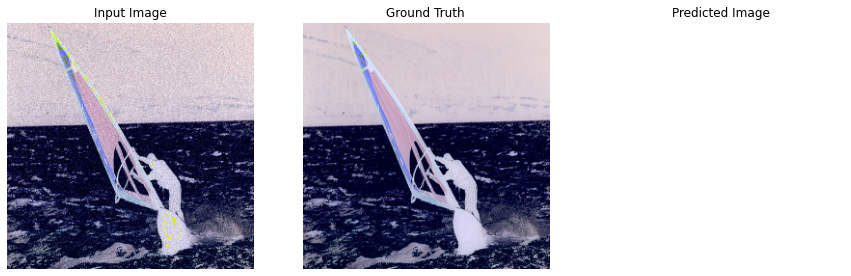

[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1. 

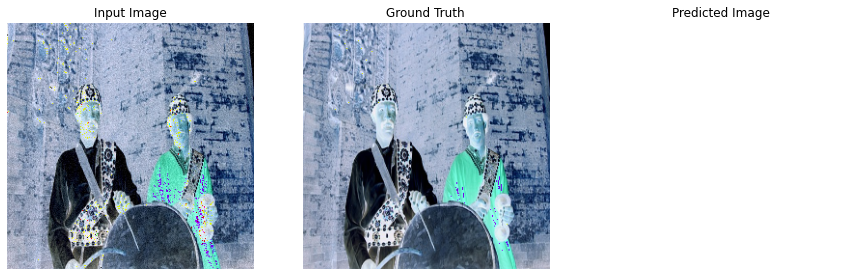

[[[[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]]

  [[1.         1.         1.        ]
   [1. 

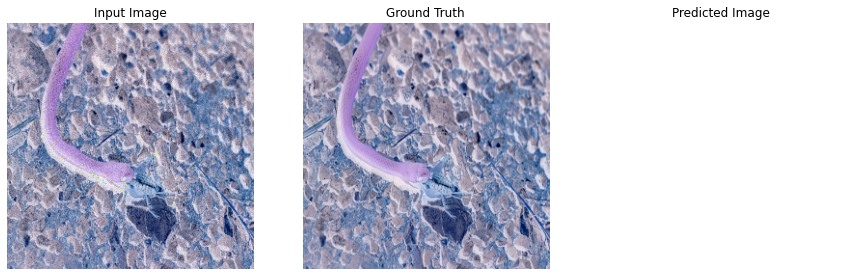

In [123]:
for inp, tar in test_dataset.take(5):
  generate_images(autoencoder, inp, tar)